In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from bs4 import BeautifulSoup
import requests
%matplotlib inline

## LOAD RESOURCES ##

In [189]:
path = 'resources/extended_dataset.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


## SOME CLEANING ##

In [190]:
count_by_zip = df[['Zip', 'Inspection ID']].groupby('Zip').count().rename(columns={'Inspection ID' : 'Count'}).sort_values('Count')
count_by_zip.head(10)

,Count
Zip,
60148,1
60559,1
60627,2
60501,4
60666,25
0,47
60827,134
60633,341
60655,794


We remove the zip codes where we have too few inspections to have significative results.

In [192]:
df_filtered = df_filtered[(df_filtered['Zip'] != 60148) & (df_filtered['Zip'] != 60559) & (df_filtered['Zip'] != 60627) & (df_filtered['Zip'] != 60501) & (df_filtered['Zip'] != 60666) & (df_filtered['Zip'] != 0)]

## SCRAP DATA ONLINE ##

We remove the zip code '0' and also the ones we know we cannot find on the website we scrap

In [193]:
zip_codes = np.sort(df_filtered['Zip'].unique())
zip_codes

array([60601, 60602, 60603, 60604, 60605, 60606, 60607, 60608, 60609,
       60610, 60611, 60612, 60613, 60614, 60615, 60616, 60617, 60618,
       60619, 60620, 60621, 60622, 60623, 60624, 60625, 60626, 60628,
       60629, 60630, 60631, 60632, 60633, 60634, 60636, 60637, 60638,
       60639, 60640, 60641, 60642, 60643, 60644, 60645, 60646, 60647,
       60649, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60659,
       60660, 60661, 60707, 60827])

In [198]:
try:
    df_zip_codes = pd.read_parquet('resources/zip_infos.parquet')
except:
    population_densities = []
    diversity_indexes = []
    median_household_incomes = []
    per_capita_incomes = []
    wealth_indexes = []

    for i, zip_code in enumerate(zip_codes):
        URL = 'https://illinois.hometownlocator.com/zip-codes/data,zipcode,{}.cfm'.format(zip_code)
        r = requests.get(URL)
        page_body = r.text
        soup = BeautifulSoup(page_body, 'html.parser')
        all_tables = soup.find_all('table')
        for table in all_tables:
            all_tr = table.find_all('tr')
            for tr in all_tr:
                all_td = tr.find_all('td')
                if len(all_td) >= 2:
                    if all_td[0].text == 'Population Density':
                        population_density = all_td[1].text.replace(',', '.')
                        population_densities.append(population_density)
                    if all_td[0].text == 'Diversity Index1':
                        diversity_index = all_td[1].text
                        diversity_indexes.append(diversity_index)
                    if all_td[0].text == 'Median Household Income' and not all_td[1].text.startswith('#'):
                        median_household_income = all_td[1].text[1:].replace(',', '.')
                        if median_household_income != '':
                            median_household_incomes.append(median_household_income)
                    if all_td[0].text == 'Per Capita Income' and not all_td[1].text.startswith('#'):
                        per_capita_income = all_td[1].text[1:].replace(',', '.')
                        if per_capita_income != '':
                            per_capita_incomes.append(per_capita_income)
                    if all_td[0].text == 'Wealth Index3':
                        wealth_index = all_td[1].text
                        wealth_indexes.append(wealth_index)

    dict_ = {'Zip' : zip_codes, 'Diversity index' : diversity_indexes, 'Median household income' : median_household_incomes, 'Per capita income' : per_capita_incomes, 'Wealth index' : wealth_indexes}
    df_zip_codes = pd.DataFrame(dict_, dtype=float).set_index('Zip')
    
df_zip_codes.head()

,Diversity index,Median household income,Per capita income,Wealth index
Zip,,,,
60601.0,60.0,112.683,91.269,120.0
60602.0,57.0,100.105,71.987,116.0
60603.0,61.0,123.197,84.558,174.0
60604.0,60.0,132.745,125.745,193.0
60605.0,64.0,102.573,73.803,127.0


## SAVE THE DATA COLLECTED ONLINE ##

In [199]:
df_zip_codes.to_parquet('resources/zip_infos.parquet')

## HAVE WE A CORRELATION BETWEEN THE NUMBER OF VIOLATIONS AND THE ZIP CODE'S LEVEL OF LIFE ? ##

In [201]:
mean_nb_violations_by_zip = df_filtered[['Zip', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Zip').mean()
mean_nb_violations_by_zip.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Zip,,,,
60601,2.533744,0.229584,0.197843,2.106317
60602,2.704045,0.273243,0.205110,2.225692
60603,2.442857,0.241270,0.238095,1.963492
60604,2.764158,0.266874,0.197828,2.299457
60605,2.782092,0.335366,0.296213,2.150513


In [202]:
df_joined_nb_violations = mean_nb_violations_by_zip.join(df_zip_codes)
df_joined_nb_violations.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,Diversity index,Median household income,Per capita income,Wealth index
Zip,,,,,,,,
60601,2.533744,0.229584,0.197843,2.106317,60.0,112.683,91.269,120.0
60602,2.704045,0.273243,0.205110,2.225692,57.0,100.105,71.987,116.0
60603,2.442857,0.241270,0.238095,1.963492,61.0,123.197,84.558,174.0
60604,2.764158,0.266874,0.197828,2.299457,60.0,132.745,125.745,193.0
60605,2.782092,0.335366,0.296213,2.150513,64.0,102.573,73.803,127.0


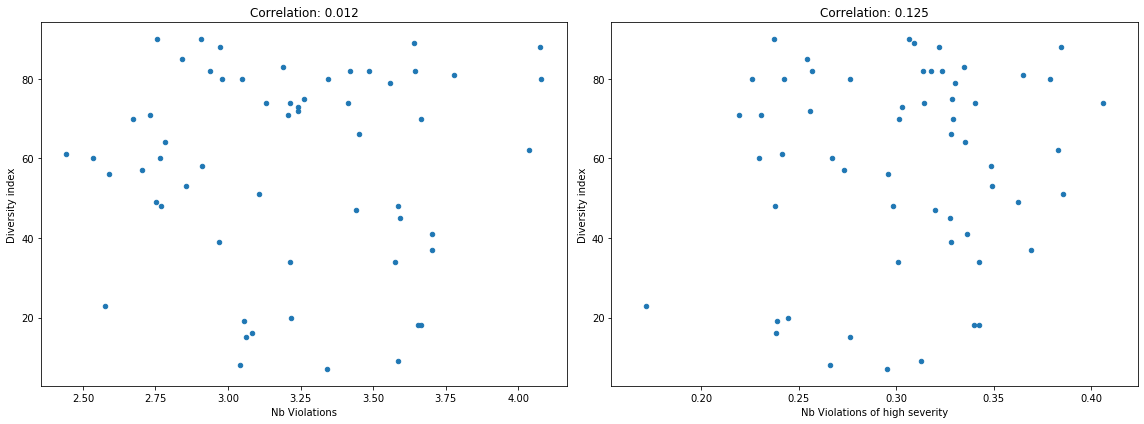

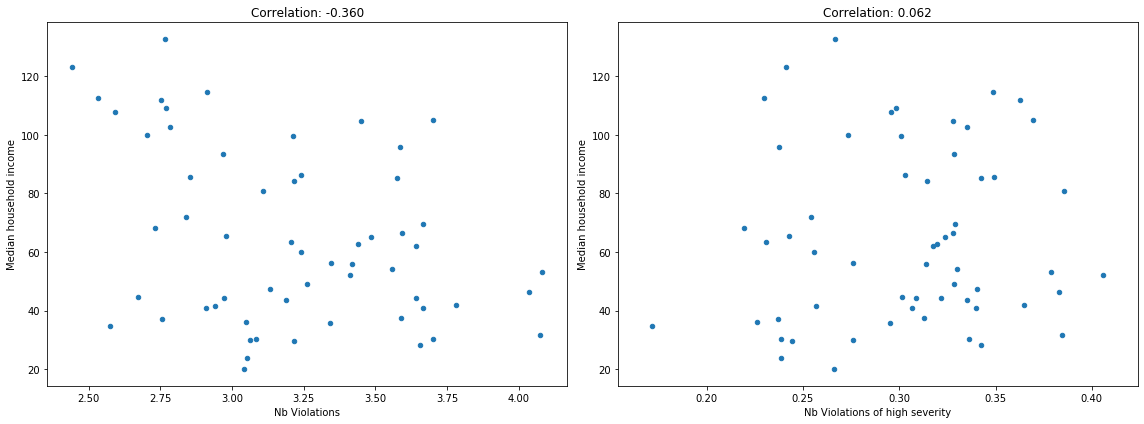

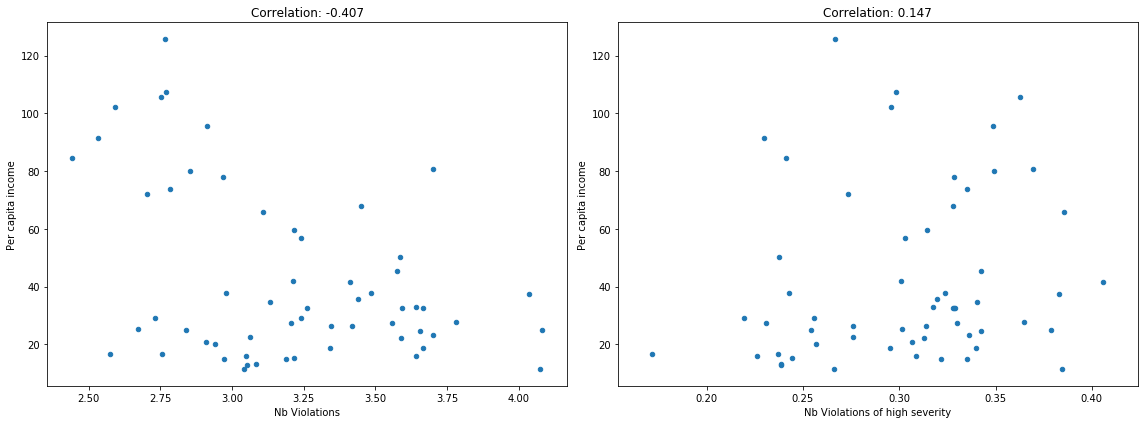

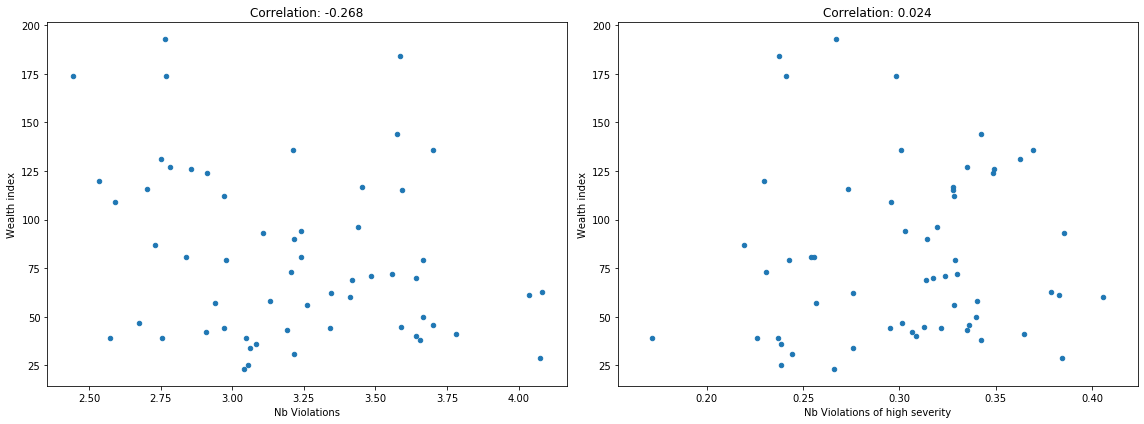

In [203]:
for column_name1 in df_zip_codes.columns:
    fig, ax = plt.subplots(1, len(mean_nb_violations_by_zip.columns[:2]), figsize=(16,6))
    
    for i, column_name2 in enumerate(mean_nb_violations_by_zip.columns[:2]):
        df_joined_nb_violations[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_nb_violations[column_name2].corr(df_joined_nb_violations[column_name1])))
    
    plt.tight_layout()
    plt.show()

We find no particular correlation.

## HAVE WE A CORRELATION BETWEEN THE NUMBER OF PASS/FAILS AND THE ZIP CODE'S LEVEL OF LIFE ? ##

In [204]:
results_by_zip = df_filtered[['Zip', 'Results']]
results_by_zip['Pass'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Pass' else 0)
results_by_zip['Pass w/ Conditions'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Pass w/ Conditions' else 0)
results_by_zip['Fail'] = results_by_zip['Results'].apply(lambda x: 1 if x == 'Fail' else 0)
results_by_zip = results_by_zip.groupby('Zip').mean()
results_by_zip.head()

/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/globox/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,Pass,Pass w/ Conditions,Fail
Zip,,,
60601,0.655162,0.136210,0.125732
60602,0.644429,0.137686,0.141945
60603,0.614815,0.150794,0.146032
60604,0.619085,0.145074,0.126455
60605,0.572208,0.145058,0.163992


In [205]:
df_joined_results = results_by_zip.join(df_zip_codes)
df_joined_results.head()

,Pass,Pass w/ Conditions,Fail,Diversity index,Median household income,Per capita income,Wealth index
Zip,,,,,,,
60601,0.655162,0.136210,0.125732,60.0,112.683,91.269,120.0
60602,0.644429,0.137686,0.141945,57.0,100.105,71.987,116.0
60603,0.614815,0.150794,0.146032,61.0,123.197,84.558,174.0
60604,0.619085,0.145074,0.126455,60.0,132.745,125.745,193.0
60605,0.572208,0.145058,0.163992,64.0,102.573,73.803,127.0


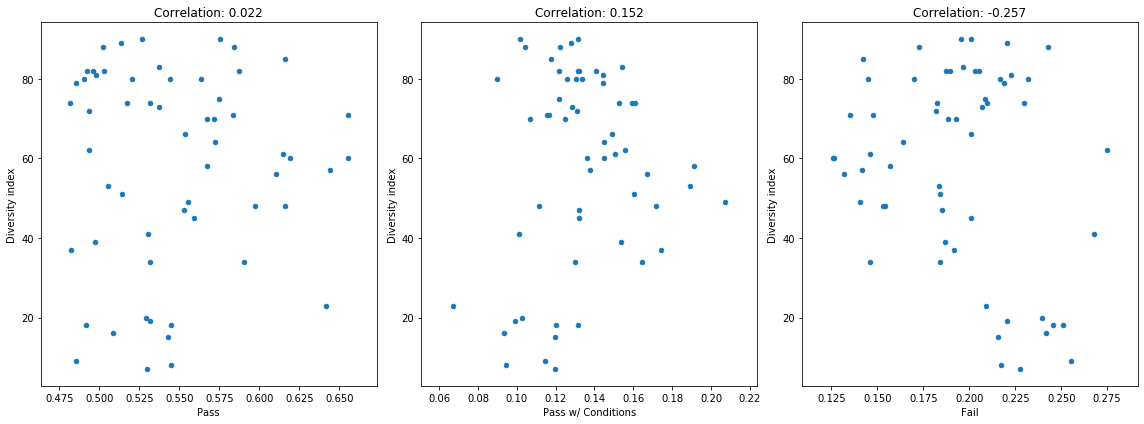

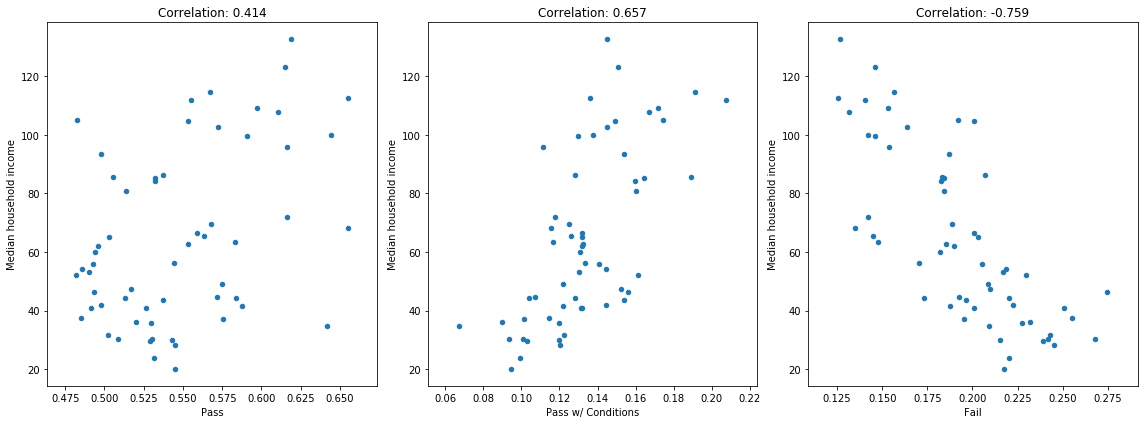

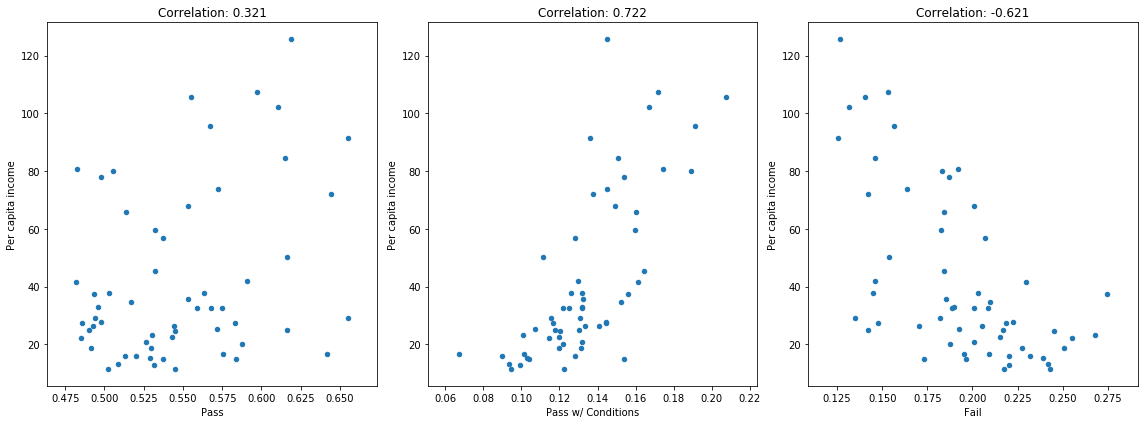

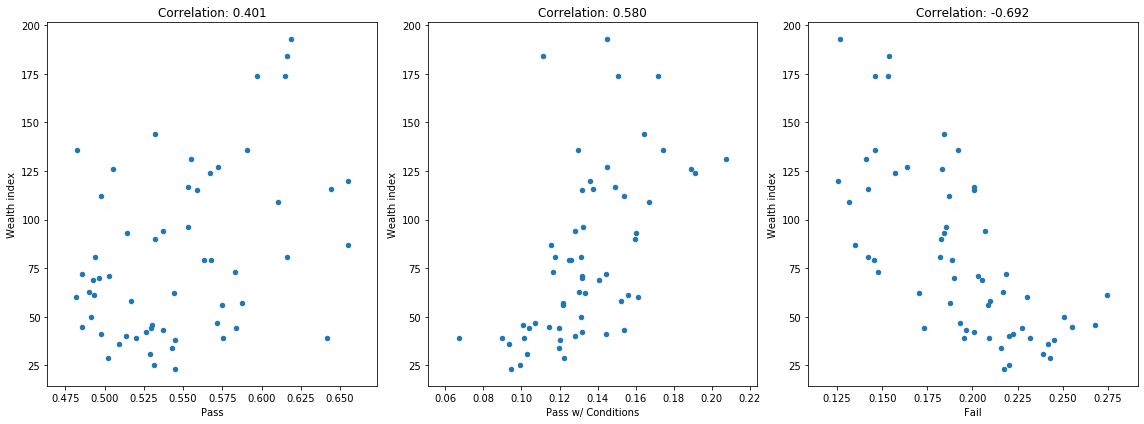

In [206]:
for column_name1 in df_zip_codes.columns:
    fig, ax = plt.subplots(1, len(results_by_zip.columns), figsize=(16,6))
    for i, column_name2 in enumerate(results_by_zip.columns):
        df_joined_results[[column_name2, column_name1]].plot.scatter(x=column_name2, y=column_name1, ax=ax[i])
        ax[i].set_title('Correlation: {}'.format("%.3f" % df_joined_results[column_name2].corr(df_joined_results[column_name1])))

    plt.tight_layout()
    plt.show()

This time we seem to have some linear correlations ! Yay !